<h1 style="margin-bottom: 50px;" id="section-0"><b>Supplementary File 3</b></h1>
<h5 style="margin-bottom: 2px; margin-top: 0px;" id="section-0.1">
    <b><span style="color: green;">[BooLEVARD]</span> Processing Boolean Models from Cell Collective</b>
</h5>
<p>
In this tutorial, we present a workflow for processing Boolean models available in Cell Collective using BooLEVARD. The pipeline involves the following steps:

1. **Importing** a model in *SBML-qual* format (Cell Collective default).
2. **Converting** the model to *BoolNet* format (BooLEVARD's input).
3. **Loading** the model into **BooLEVARD** to compute path-count-based transduction scores toward every non-input node within the model.
4. **Extracting** stable state analysis results to determine the binary activation state (0 or 1) of the non-input nodes within the model.

In addition to the transduction scores and stable states, we provide metadata for each example, including:
- Total numbber of nodes,
- Number of computed *stable states*,
- Total count of *activating and inhibitory paths*.
- And the *runtime* required for each computation step.

We apply this workflow to six publicly available Boolean models from Cell Collective:

- **T Cell Receptor Signaling** <a href="#section-1">[visit]</a><br>
- **Guard Cell Abscisic Acid Signaling**<a href="#section-2"> [visit]</a><br>
- **T-LGL Survival Network**<a href="#section-3"> [visit]</a><br>
- **HGF Signaling in Keratinocytes**<a href="#section-4"> [visit]</a><br>
- **Bortezomib Responses in U266 Human Myeloma Cells**<a href="#section-5"> [visit]</a><br>
- **MAPK Cancer Cell Fate Network**<a href="#section-6"> [visit]</a><br>
- **IL-1 Signaling**<a href="#section-7"> [visit]</a><br>
- **IL-6 Signaling**<a href="#section-8"> [visit]</a><br>
- **Tumor Cell Invasion**<a href="#section-9"> [visit]</a><br>

This use case illustrates how mechanistic information encoded in the Boolean equations (captured by transduction path counts) can be systematically compared with the emergent behavior of the system derived from its stable states.

In [ ]:
import biolqm
import tempfile
import time
import re
import mpbn
import contextlib
import io
import sys
import xml.etree.ElementTree as ET
import boolevard as blv
import pandas as pd
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
from PyComplexHeatmap import * 
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import LogLocator, NullFormatter

Below we define the functions that will be used to convert the SBML models from Cell Collective into BoolNet format, generate a heatmap that compares stable state results with BooLEVARD's output (path counts), and a dataframe storing some metadata, including simulation times, number of stable states, and number of counted paths.

In [2]:
# Extract qualitative species IDs and names from SBML-qual file
def extract_qualids(sbml_file):
    ns = {"qual": "http://www.sbml.org/sbml/level3/version1/qual/version1"}
    tree = ET.parse(sbml_file)
    root = tree.getroot()
    id2name = {}
    for q in root.findall(".//qual:qualitativeSpecies", ns):
        qid = q.attrib.get("{http://www.sbml.org/sbml/level3/version1/qual/version1}id")
        name = q.attrib.get("{http://www.sbml.org/sbml/level3/version1/qual/version1}name", qid)
        if qid and name:
            id2name[qid] = name
    return id2name

# Convert SBML-qual model to bnet format
def sbml2bnet(sbml_file, output_file):
    try:
        model = biolqm.load(sbml_file)
        id2name = extract_qualids(sbml_file)
        with tempfile.NamedTemporaryFile("w+", delete=False, suffix=".bnet") as f:
            biolqm.save(model, f.name, "bnet")
            f.seek(0)
            lines = f.readlines()
        new_lines = []
        id_pattern = re.compile(r'\b({})\b'.format('|'.join(map(re.escape, id2name.keys()))))
        for line in lines:
            if line.startswith("#") or "," not in line:
                new_lines.append(line)
                continue
            target, expr = map(str.strip, line.split(",", 1))
            target = id2name.get(target, target).replace(",", "_").replace("/", "_").replace("+", "").replace("-", "__").replace("(", "").replace(")", "")
            expr = id_pattern.sub(lambda m: id2name[m.group(0)], expr)
            expr = expr.replace("&", " & ").replace("/", "_").replace(",", "_").replace("+", "").replace("-", "__").replace("(", "").replace(")", "")
            new_lines.append(f"{target}, {expr}\n")
        with open(output_file, "w") as out:
            out.writelines(new_lines)
        print(f"✅ SBML-qual model successfully converted to bnet: {output_file}")
    except Exception as e:
        print(f"❌ Error: {e}")

# Get simulation times
def simmulation_summary(model, pc):
    n_paths = np.abs(pc).sum()
    n_nodes = len(model.Nodes)
    n_inputs = len(model.Info.index[model.Info.index == model.Info["DNF"].apply(str)])
    n_stable_states = len(pc)
    avg_stime_ss = sim_time / n_stable_states
    avg_stime_node = sim_time / n_stable_states / n_nodes
    avg_stime_path = sim_time / n_paths
    sum = pd.DataFrame([{
        "Simulation time (s)": sim_time,
        "Stable states": n_stable_states,
        "Nodes": n_nodes,
        "Edges": edges,
        "Inputs": n_inputs,
        "Paths": n_paths,
        "Avg time / state (s)": avg_stime_ss,
        "Avg time / node (s)": avg_stime_node,
        "Avg time / path (s)": avg_stime_path
    }])
    return sum

# Perform analysis using BooLEVARD
def Report(model, paths, base = 4):
    def log_signed(x, base):
        return np.sign(x) * np.log1p(np.abs(x)) / np.log(base)
    inputs = model.Info.index[model.Info.index == model.Info["DNF"].apply(str)]
    # Transduction:
    paths_sum = pd.DataFrame(paths)
    paths_sum.columns = nodes
    paths_sum = paths_sum.loc[:, ~paths_sum.columns.isin(inputs)]
    paths_sum = log_signed(paths_sum, base)
    # Local states:
    ls_info = model.Info.loc[nodes, model.Info.columns[:-2]].transpose()
    ls_info = ls_info.loc[:, ~ls_info.columns.isin(inputs)]
    ls_info.index = paths_sum.index
    ### Plot heatmap ###
    row_linkage = linkage(paths_sum.values, method="average", metric="euclidean")
    col_linkage = linkage(paths_sum.values.T, method="average", metric="euclidean")
    row_order = leaves_list(row_linkage)
    col_order = leaves_list(col_linkage)
    row_labels = paths_sum.index[row_order]
    col_labels = paths_sum.columns[col_order]
    paths_sum = paths_sum.loc[row_labels, col_labels]
    ls_info = ls_info.loc[row_labels, col_labels]

    colors_row_ha = {input_name: {"0": "#eeeeee", "1": "#212121"} for input_name in inputs}
    # Annotations
    annot_ls = pd.DataFrame(["Local State"]*(len(nodes)-len(inputs)), columns = ["Score"])
    annot_paths = pd.DataFrame(["Path Count"]*(len(nodes)-len(inputs)), columns = ["Score"])
    annot_inputs = model.Info.loc[inputs, model.Info.columns[:-2]].transpose().astype(str)
    annot_inputs.index = paths_sum.index
    row_ha_inputs = HeatmapAnnotation(df = annot_inputs, colors = colors_row_ha, plot = False, legend = False, axis = 0, label_kws = dict(size = 9), label_side = "bottom", wgap = 0.01, plot_kws = dict(linewidth = 0.001, linecolor = "white", linestyle = ":"), legend_width=90) # Annotation for inputs
    # - Subheatmap 1: Local States
    cmap_ls = ListedColormap(["#eeeeee", "#212121"])
    hmap_ls = ClusterMapPlotter(
        ls_info.astype(int),
        row_cluster = False, col_cluster = False,
        show_rownames = True, show_colnames = True,
        cmap = cmap_ls, linewidths = 0.001, linecolor = "white",
        plot = False,
        plot_legend = True, label = "Local States",
        left_annotation = row_ha_inputs,
        xlabel = "Local States",
        xlabel_kws=dict(color='black',fontsize = 10,labelpad=7, x = 1, ha = "center"),
        xticklabels_kws=dict(size=1),
        xlabel_side='top'
    )
    # - Subheatmap 2: Path Count
    cmap_paths = LinearSegmentedColormap.from_list("custom_diverging", ["#696bd4", "#FFFFFF", "#e55451"], N = 256)
    vmax_paths = np.max(np.abs(paths_sum.values))
    hmap_paths = ClusterMapPlotter(
        paths_sum,
        row_cluster = False, col_cluster = False,
        show_rownames = True, show_colnames = True,
        left_annotation = row_ha_inputs,
        cmap = cmap_paths, vmin = -vmax_paths, vmax = vmax_paths,
        linewidths = 0.001, linecolor = "white",
        plot = False,
        plot_legend = True, label = "Log4PC",
        xlabel = "Log4-PathCounts",
        xlabel_kws=dict(color='black',fontsize=10,labelpad=7, x = 1, ha = "center"),
        xlabel_side='top'
    )
    return[hmap_ls, hmap_paths]

We set the environment to run the analysis across the models:
- sbml_dir holding the models from Cell Collective.
- bnet_dir storing the models in bnet format.
- models_repo including the model names

In [3]:
# Conversion from SBML to BoolNet

# BoolNet and SBML directories
sbml_dir = "../tutorials/resources/CellCollectiveModels/sbml/"
bnet_dir = "../tutorials/resources/CellCollectiveModels/bnet/"

# Models #
models_repo = [
    "T Cell Receptor Signaling (SBML)",
    "Guard Cell Abscisic Acid Signaling (SBML)",
    "T-LGL Survival Network 2011 (SBML)",
    "HGF Signaling in Keratinocytes (SBML)",
    "_Bortezomib Responses in U266 Human Myeloma Cells (SBML)",
    "MAPK Cancer Cell Fate Network (SBML)",
    "IL-1 Signaling (SBML)",
    "IL-6 Signalling (SBML)",
    "Tumour Cell Invasion and Migration (SBML)"
]

<h4 style="margin-top: 0px; margin-bottom: 2px;"><b>Generate reports</b></h4>
<h5 style="margin-top: 20px; margin-bottom: 2px;" id="section-1"><b>1.- T Cell Receptor Signaling</b><a href="#section-0" style="font-size: 12px;"> [back]</a></h5>

<p>
This model represents the activation of primary T lymphocytes, key regulators of the adaptive immune response. Unlike many existing models, which are often based on data from transformed T cell lines, this network was constructed integrating experimental findings specifically from non-transformed, primary T cells. The model captures key signaling events triggered by the engagement of the T Cell Receptor (TCR), CD4/CD8 co-receptors, and the co-stimulatory molecule CD28. Therefore, it enables the in silico exploration of T cell activation pathways and was used to uncover non-obvious signaling routes, such asthose involving CD28 and the kinase Fyn. 
</p>
<p style="font-size:90%; color:gray;">
Saez-Rodriguez J, Simeoni L, Lindquist JA, Hemenway R, Bommhardt U, et al. (2007).  
<i>A Logical Model Provides Insights into T Cell Receptor Signaling.</i>  
PLOS Computational Biology 3(8): e163.  
<a href="https://doi.org/10.1371/journal.pcbi.0030163" target="_blank">https://doi.org/10.1371/journal.pcbi.0030163</a>
</p>

In [4]:
# Run analysis
# Select model and convert SBML to BoolNet format
model_name = models_repo[0]
model_path = f"{bnet_dir}{model_name}.bnet"
sbml2bnet((f"{sbml_dir}{model_name}.sbml"), (f"{bnet_dir}{model_name}.bnet"))
# Load the BoolNet model, extract nodes and count paths
model = blv.Load(model_path)
nodes = model.Nodes
edges = 158
sys.stdout = open(os.devnull, 'w')
start_time = time.time()
pc = model.CountPaths(nodes, ss_wise = True)
end_time = time.time()
sys.stdout = sys.__stdout__
sim_time = end_time - start_time
ls, paths = Report(model, pc) # ls will contain stable state analysis results and paths will contain BooLEVARD's results


✅ SBML-qual model successfully converted to bnet: ../tutorials/resources/CellCollectiveModels/bnet/T Cell Receptor Signaling (SBML).bnet


✅ SBML-qual model successfully converted to bnet: ../tutorials/resources/CellCollectiveModels/bnet/Guard Cell Abscisic Acid Signaling (SBML).bnet
✅ SBML-qual model successfully converted to bnet: ../tutorials/resources/CellCollectiveModels/bnet/T-LGL Survival Network 2011 (SBML).bnet
✅ SBML-qual model successfully converted to bnet: ../tutorials/resources/CellCollectiveModels/bnet/HGF Signaling in Keratinocytes (SBML).bnet
✅ SBML-qual model successfully converted to bnet: ../tutorials/resources/CellCollectiveModels/bnet/_Bortezomib Responses in U266 Human Myeloma Cells (SBML).bnet
✅ SBML-qual model successfully converted to bnet: ../tutorials/resources/CellCollectiveModels/bnet/MAPK Cancer Cell Fate Network (SBML).bnet
✅ SBML-qual model successfully converted to bnet: ../tutorials/resources/CellCollectiveModels/bnet/IL-1 Signaling (SBML).bnet
✅ SBML-qual model successfully converted to bnet: ../tutorials/resources/CellCollectiveModels/bnet/IL-6 Signalling (SBML).bnet
✅ SBML-qual model 

Simulation time (s),Stable states,Nodes,Edges,Inputs,Paths,Avg time / state (s),Avg time / node (s),Avg time / path (s)
16.047755,104,101,158,7,490156,0.154305,0.001528,0.000033


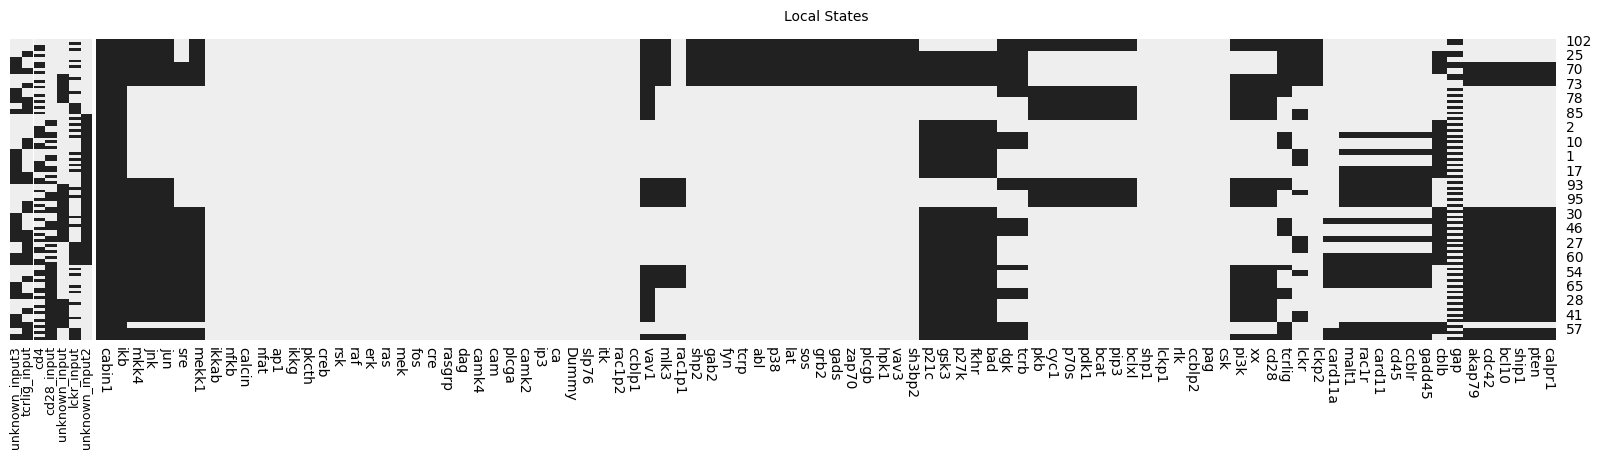

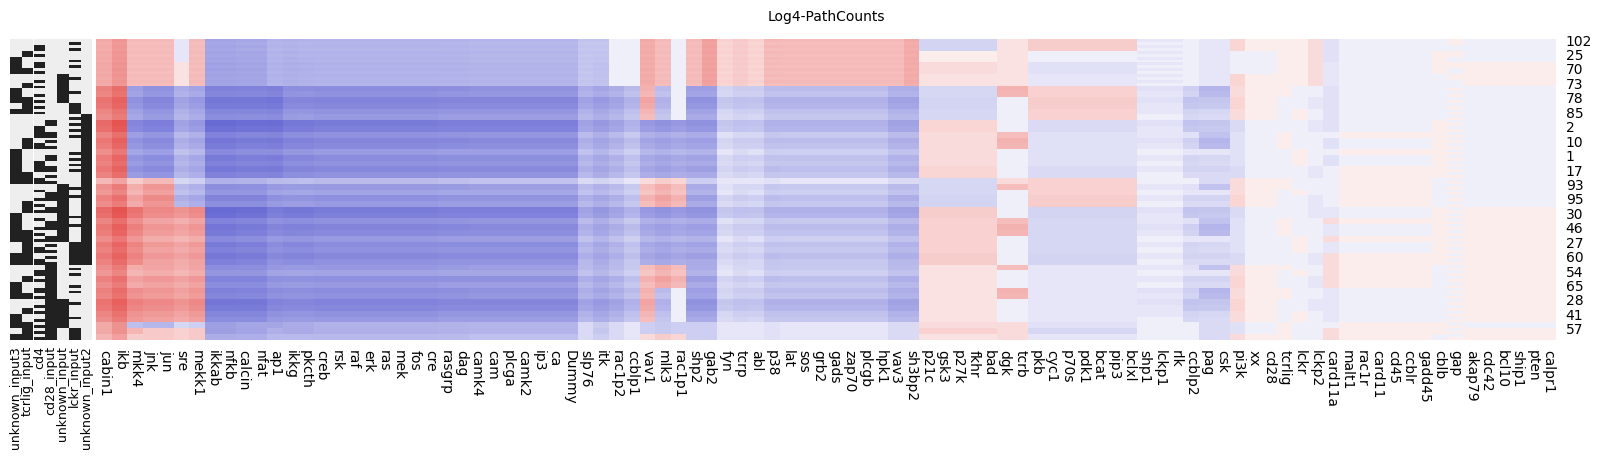

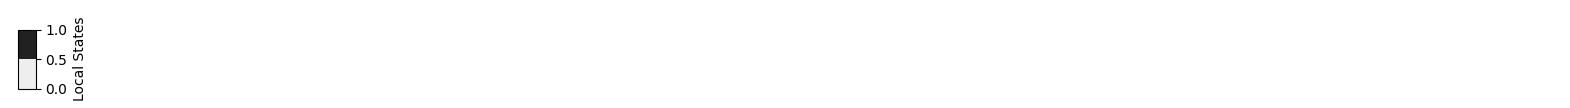

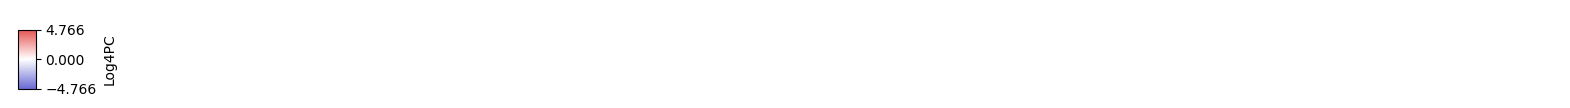

In [5]:
# Plot Report
sim_sum1 = simmulation_summary(model, pc)
display(sim_sum1.style.hide(axis = "index"))
with contextlib.redirect_stdout(io.StringIO()):
    plt.figure(figsize=(20, 4)); ls.plot()
    plt.figure(figsize=(20, 4)); paths.plot()
    plt.figure(figsize=(20, 1)); ls.plot_legends()
    plt.figure(figsize=(20, 1)); paths.plot_legends()

<div style="font-size:90%;">

**Figure 1.** Heatmaps showing the Boolean states (top) and the corresponding transduction path counts (bottom), calculated using BooLEVARD, for the stable states reached by the T Cell Receptor Signaling Boolean model. The Boolean activation states of the input nodes (*unknown_input3*, *tcrlig_input*, *cd28_input*, *unknown_input*, *lckr_input*, and *unknown_input*) that drive each stable state are shown to the left of both heatmaps (black = ON, white = OFF). Path counts are shown on a signed logarithmic scale (Log₄ of the number of activating or inhibitory paths). Red indicates a high number of activating paths toward a node; blue indicates inhibitory paths. Rows (stable states) and columns (nodes) have been clustered using Euclidean distance to highlight patterns across conditions and model components.

</div>

In the present and following examples, this visualization highlights the additional layer of information provided by **BooLEVARD** beyond the binary output of stable state analysis. Within each individual state, we can observe differences in the number of activating and inhibitory paths converging onto each node. These differences reflect both the topological positioning of each node (i.e. how upstream or downstream it is within the network) and the structural redundancy of the signaling routes that lead to its activation or repression. Moreover, by comparing across stable states, we can identify cases where different input combinations lead to identical binary states for certain nodes, yet exhibit marked differences in their transduction path profiles. Such cases may indicate nodes that are **functionally stable but topologically variable**, revealing hidden dependencies or alternative pathways that are not apparent from Boolean outputs alone. This enables a richer understanding of signal integration and robustness within the network.

<h5 style="margin-top: 00px; margin-bottom: 2px;" id="section-2"><b>2.- Guard Cell Abscisic Acid</b><a href="#section-0" style="font-size: 12px;"> [back]</a><br></h5>
<p>

This model describes the signaling network underlying **ABA-induced stomatal closure** in plant guard cells. Stomata are microscopic pores on th leaf surface that regulate gas exchange, and their aperture is tightly controlled by a pair of guard cells. In response to drought, the hormone abscisic acid (ABA) promotes stomatal closure to minimize water loss. This complex physiological response involves a broad aarray of molecular components, including ion channels, secondary messengers, and cytoskeletal regulators. The model integrates more than 40 experimetally characterized components into a unified **signal transduction network** that captures the main regulatory interactions driving guard cell shrinkage and stomatal closure. It successfully reproduces known physiological and pathway-level respones to ABA.

</p>
<p style="font-size:90%; color:gray;">
Li S, Assmann SM, Albert R (2006).  
<i>Predicting Essential Components of Signal Transduction Networks: A Dynamic Model of Guard Cell Abscisic Acid Signaling.</i>  
PLOS Biology 4(10): e312.  
<a href="https://doi.org/10.1371/journal.pbio.0040312" target="_blank">https://doi.org/10.1371/journal.pbio.0040312</a>
</p>


In [6]:
# Run analysis
# Select model and convert SBML to BoolNet format
model_name = models_repo[1]
model_path = f"{bnet_dir}{model_name}.bnet"
sbml2bnet((f"{sbml_dir}{model_name}.sbml"), (f"{bnet_dir}{model_name}.bnet"))
# Load the BoolNet model, extract nodes and count paths
model = blv.Load(model_path)
nodes = model.Nodes; edges = 78
sys.stdout = open(os.devnull, 'w')
start_time = time.time()
pc = model.CountPaths(nodes, ss_wise = True)
end_time = time.time()
sys.stdout = sys.__stdout__
sim_time = end_time - start_time
ls, paths = Report(model, pc) # ls will contain stable state analysis results and paths will contain BooLEVARD's results

Simulation time (s),Stable states,Nodes,Edges,Inputs,Paths,Avg time / state (s),Avg time / node (s),Avg time / path (s)
0.559653,16,44,78,4,2374,0.034978,0.000795,0.000236


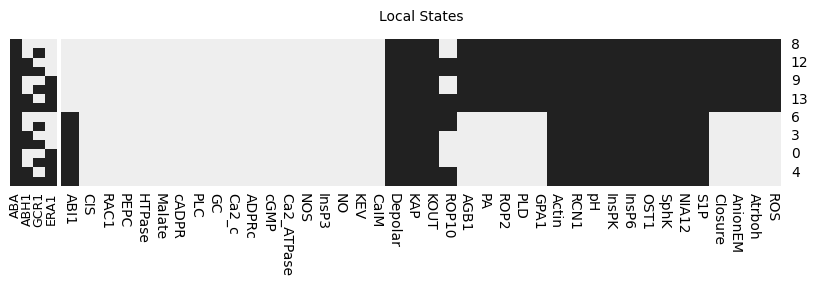

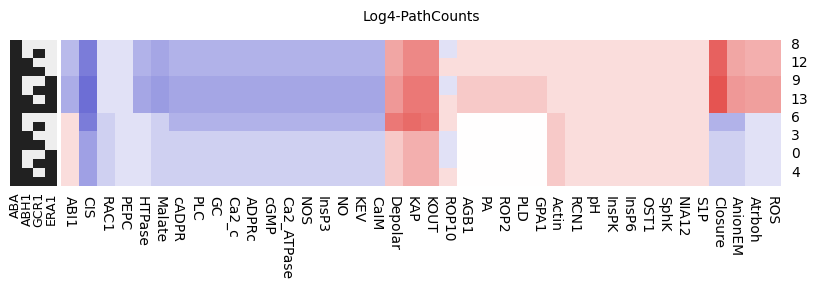

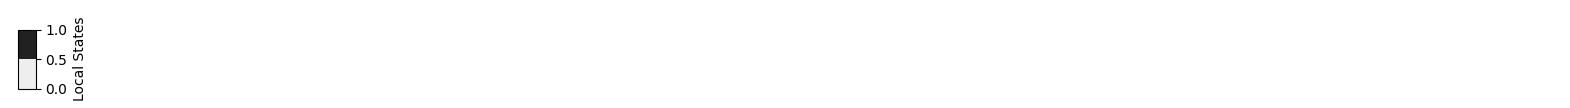

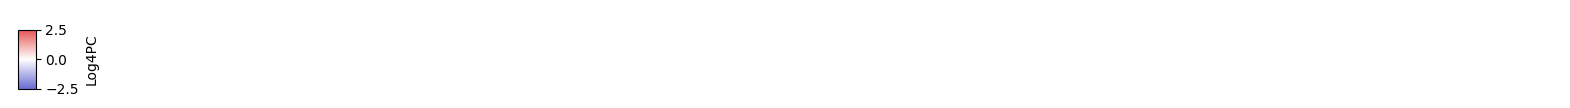

In [7]:
# Plot Report
sim_sum2 = simmulation_summary(model, pc)
display(sim_sum2.style.hide(axis = "index"))
with contextlib.redirect_stdout(io.StringIO()):
    plt.figure(figsize=(10, 2)); ls.plot()
    plt.figure(figsize=(10, 2)); paths.plot()
    plt.figure(figsize=(20, 1)); ls.plot_legends()
    plt.figure(figsize=(20, 1)); paths.plot_legends()

<div style="font-size:90%;">

**Figure 2.** Heatmaps showing the Boolean states (top) and the corresponding transduction path counts (bottom), calculated using BooLEVARD, for the stable states reached by the Guard Cell Ascibic Acid Boolean model. The Boolean activation states of the input nodes (*ABA*, *ABH1*, *GCR1* and *ERA1*) that drive each stable state are shown to the left of both heatmaps (black = ON, white = OFF). Path counts are shown on a signed logarithmic scale (Log₄ of the number of activating or inhibitory paths). Red indicates a high number of activating paths toward a node; blue indicates inhibitory paths. Rows (stable states) and columns (nodes) have been clustered using Euclidean distance to highlight patterns across conditions and model components.

</div>

<h5 style="margin-top: 00px; margin-bottom: 2px;" id="section-3"><b>3.- T-LGL Survival Network</b><a href="#section-0" style="font-size: 12px;"> [back]</a></h5>
<p>

This model represents the survival signaling network of **T cell large granular lymphocyte (T-LGL) leukemia**, a disease characterized by the clonal expansion of antigen-primed, cytotoxic T lymphocytes (CTL). The model integrates key signaling pathways involved in normal CTL activation and dysregulated survival signals observed in leukemic T-LGL cells. It includes not only molecular components like proteins, mRNAs, and small molecules, but also summary nodes that represent high-level cellular processes such as *Proliferation*, *Apoptosis*, and *Cytoskeleton signaling*. Thediscrete dynamic model provides a framework for identifying potential therapeutic targets in T-LGL leukemia and for exploring mechanisms of long-term CTL survival in both pathological and immunotherapeutic contexts.
<p style="font-size:90%; color:gray;">
Zhang R, Shah MV, Yang J, Nyland SB, Liu X, Yun JK, Albert R, Loughran TP (2008).  
<i>Network Model of Survival Signaling in Large Granular Lymphocyte Leukemia.</i>  
Proceedings of the National Academy of Sciences 105(42): 16308–16313.  
<a href="https://doi.org/10.1073/pnas.0806447105" target="_blank">https://doi.org/10.1073/pnas.0806447105</a>
</p>

In [8]:
# Run analysis
# Select model and convert SBML to BoolNet format
model_name = models_repo[2]
model_path = f"{bnet_dir}{model_name}.bnet"
sbml2bnet((f"{sbml_dir}{model_name}.sbml"), (f"{bnet_dir}{model_name}.bnet"))
# Load the BoolNet model, extract nodes and count paths
model = blv.Load(model_path)
nodes = model.Nodes; edges = 195
sys.stdout = open(os.devnull, 'w')
start_time = time.time()
pc = model.CountPaths(nodes, ss_wise = True)
end_time = time.time()
sys.stdout = sys.__stdout__
sim_time = end_time - start_time
ls, paths = Report(model, pc) # ls will contain stable state analysis results and paths will contain BooLEVARD's results

Simulation time (s),Stable states,Nodes,Edges,Inputs,Paths,Avg time / state (s),Avg time / node (s),Avg time / path (s)
20.505520,82,60,195,6,14526681,0.250067,0.004168,0.000001


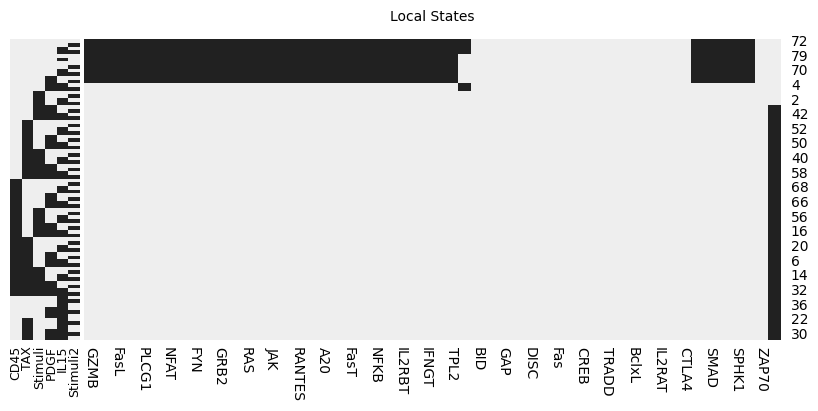

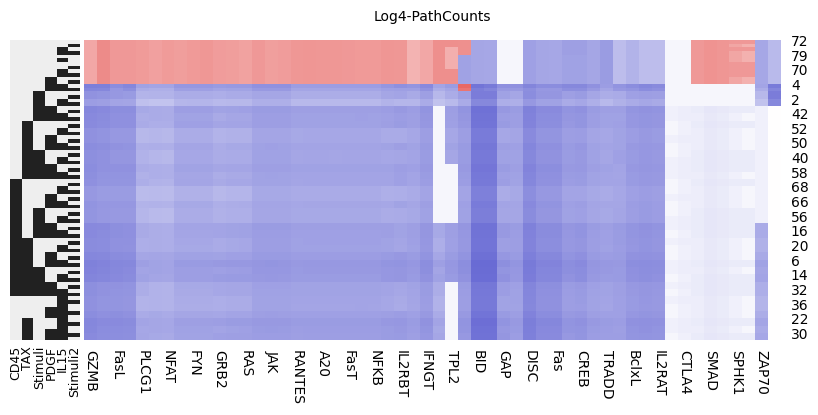

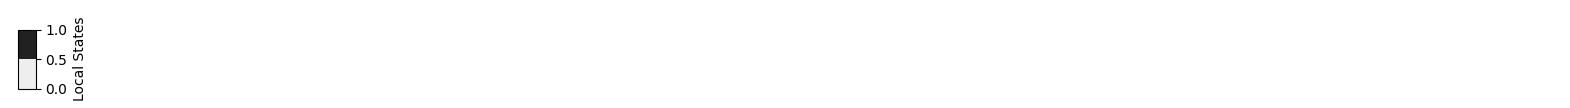

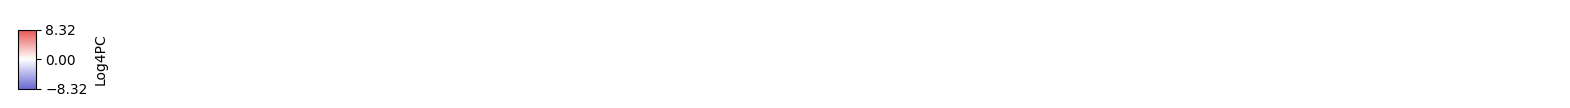

In [9]:
# Plot Report
sim_sum3 = simmulation_summary(model, pc)
display(sim_sum3.style.hide(axis = "index"))
with contextlib.redirect_stdout(io.StringIO()):
    plt.figure(figsize=(10, 4)); ls.plot()
    plt.figure(figsize=(10, 4)); paths.plot()
    plt.figure(figsize=(20, 1)); ls.plot_legends()
    plt.figure(figsize=(20, 1)); paths.plot_legends()

<div style="font-size:90%;">

**Figure 3.** Heatmaps showing the Boolean states (top) and the corresponding transduction path counts (bottom), calculated using BooLEVARD, for the stable states reached by the T-LGL Survival Network Boolean model. The Boolean activation states of the input nodes (*CD45*, *TAX*, *Stimuli*, *PDGF*, *IL15*, *Stimuli2*) that drive each stable state are shown to the left of both heatmaps (black = ON, white = OFF). Path counts are shown on a signed logarithmic scale (Log₄ of the number of activating or inhibitory paths). Red indicates a high number of activating paths toward a node; blue indicates inhibitory paths. Rows (stable states) and columns (nodes) have been clustered using Euclidean distance to highlight patterns across conditions and model components.

</div>

<h5 style="margin-top: 00px; margin-bottom: 2px;" id="section-4"><b>4.- HGF Signaling in Keratinocytes</b><a href="#section-0" style="font-size: 12px;"> [back]</a></h5>
<p>

This model describes the molecular signaling events that govern **HGF-induced migration of human keratinocytes (NHK)**, a key process in wound healing and tissue regeneration. The model integrates multiple layers of regulation, including protein signaling, gene expression, and autocrine feedback loops, to capture the full progression from initial stimulation by hepatocyte growth factor (HGF) to the execution of the migratory phenotype. The networks focuses on the dynamics of MET receptor activation, followed by downstream MAPK/ERK and p38/JNK pathway activation, and later sustained by autocrine signals involving EGF receptor and urokinase-type plasminogen activator receptor. This layered activation captures the time-dependent orchestration of early signaling and late transcriptial responses necessary for sustained migration. To reproduce this dynamic behavior, the model incorporates two distinct time scales:
- A **rapid phase** (0-1h) covering immediate protein phosphorylation events.
- A **delayed phase** (1-3h) encompassing transcriptional regulation and autocrine signaling.

This hybrid Boolean framework bridges transcriptomic data with mechanistic signaling, offering a powerful tool to explore the temporal logic of wound healing and keratinocyte migration.
<p style="font-size:90%; color:gray;">
Singh A, Nascimento JM, Kowar S, Busch H, Boerries M (2012).  
<i>Boolean Approach to Signalling Pathway Modelling in HGF-Induced Keratinocyte Migration.</i>  
Bioinformatics, 28(18): i495–i501.  
<a href="https://doi.org/10.1093/bioinformatics/bts410" target="_blank">https://doi.org/10.1093/bioinformatics/bts410</a>
</p>

In [10]:
# Run analysis
# Select model and convert SBML to BoolNet format
model_name = models_repo[3]
model_path = f"{bnet_dir}{model_name}.bnet"
sbml2bnet((f"{sbml_dir}{model_name}.sbml"), (f"{bnet_dir}{model_name}.bnet"))
# Load the BoolNet model, extract nodes and count paths
model = blv.Load(model_path)
nodes = model.Nodes; edges = 103
sys.stdout = open(os.devnull, 'w')
start_time = time.time()
pc = model.CountPaths(nodes, ss_wise = True)
end_time = time.time()
sys.stdout = sys.__stdout__
sim_time = end_time - start_time
ls, paths = Report(model, pc) # ls will contain stable state analysis results and paths will contain BooLEVARD's results

Simulation time (s),Stable states,Nodes,Edges,Inputs,Paths,Avg time / state (s),Avg time / node (s),Avg time / path (s)
5.722754,72,68,103,6,303199,0.079483,0.001169,0.000019


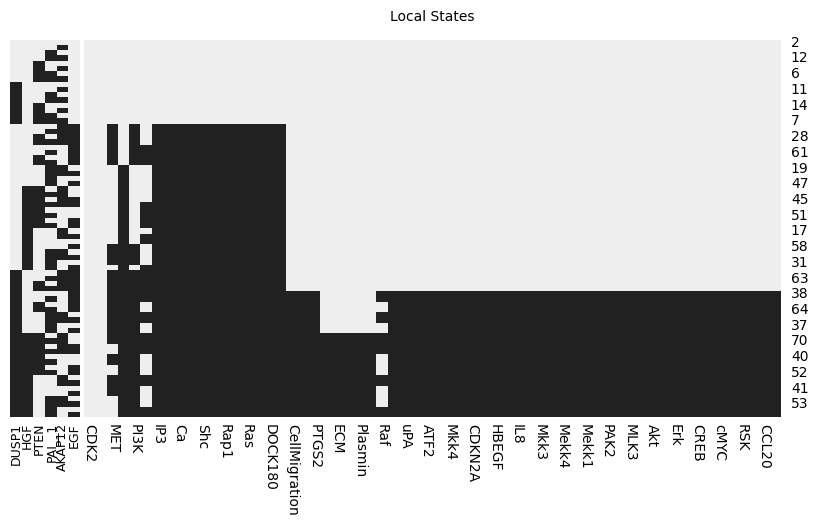

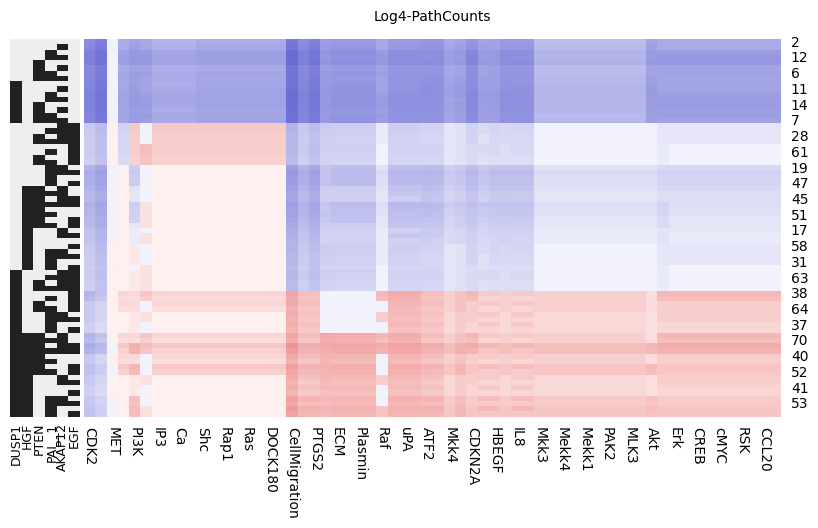

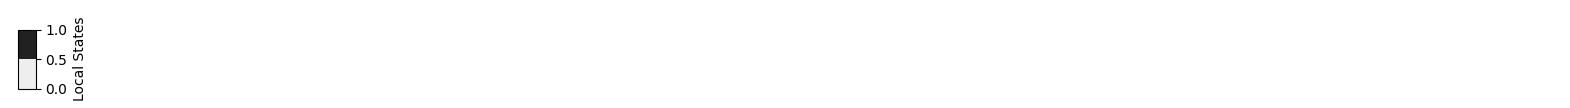

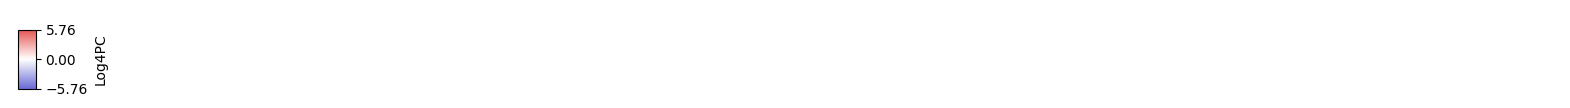

In [11]:
# Plot Report
sim_sum4 = simmulation_summary(model, pc)
display(sim_sum4.style.hide(axis = "index"))
with contextlib.redirect_stdout(io.StringIO()):
    plt.figure(figsize=(10, 5)); ls.plot()
    plt.figure(figsize=(10, 5)); paths.plot()
    plt.figure(figsize=(20, 1)); ls.plot_legends()
    plt.figure(figsize=(20, 1)); paths.plot_legends()

<div style="font-size:90%;">

**Figure 4.** Heatmaps showing the Boolean states (top) and the corresponding transduction path counts (bottom), calculated using BooLEVARD, for the stable states reached by the HGF Signaling in Kertinocytes Boolean model. The Boolean activation states of the input nodes (*DUSP1*, *HGF*, *PTEN*, *PAI_1*, *AKAP12*, *EGF*) that drive each stable state are shown to the left of both heatmaps (black = ON, white = OFF). Path counts are shown on a signed logarithmic scale (Log₄ of the number of activating or inhibitory paths). Red indicates a high number of activating paths toward a node; blue indicates inhibitory paths. Rows (stable states) and columns (nodes) have been clustered using Euclidean distance to highlight patterns across conditions and model components.

</div>

<h5 style="margin-top: 00px; margin-bottom: 2px;" id="section-5"><b>5.- Bortezomib Responses in U266 Human Myeloma Cells</b><a href="#section-0" style="font-size: 12px;"> [back]</a></h5>
<p>

This model represents the signaling pathways regulating **cell survival and apoptosis in U266 multiple myeloma (MM) cells**, with a focus on understanding the cytotoxic effects of bortezomib, a proteasome inhibitor used as first-line therapy in MM. The network integrates major signaling axes such as NFkB, JAK/STAT, and Bcl-2 family proteins. The model illustrate how discrete logic-based models can be coupled with drug response dynamics to explore therapeutic mechanisms and rationale discrepancies between expected and observed outcomes.
<p style="font-size:90%; color:gray;">
Chudasama VL, Ovacik MA, Abernethy DR, Mager DE (2015).  
<i>Logic-Based and Cellular Pharmacodynamic Modeling of Bortezomib Responses in U266 Human Myeloma Cells.</i>  
The Journal of Pharmacology and Experimental Therapeutics, 354(3): 448–458.  
<a href="https://doi.org/10.1124/jpet.115.224766" target="_blank">https://doi.org/10.1124/jpet.115.224766</a>
</p>

In [12]:
# Run analysis
# Select model and convert SBML to BoolNet format
model_name = models_repo[4]
model_path = f"{bnet_dir}{model_name}.bnet"
sbml2bnet((f"{sbml_dir}{model_name}.sbml"), (f"{bnet_dir}{model_name}.bnet"))
# Load the BoolNet model, extract nodes and count paths
model = blv.Load(model_path)
nodes = model.Nodes; edges = 131
sys.stdout = open(os.devnull, 'w')
start_time = time.time()
pc = model.CountPaths(nodes, ss_wise = True)
end_time = time.time()
sys.stdout = sys.__stdout__
sim_time = end_time - start_time
ls, paths = Report(model, pc) # ls will contain stable state analysis results and paths will contain BooLEVARD's results

Simulation time (s),Stable states,Nodes,Edges,Inputs,Paths,Avg time / state (s),Avg time / node (s),Avg time / path (s)
8.332357,83,67,131,5,1616931,0.100390,0.001498,0.000005


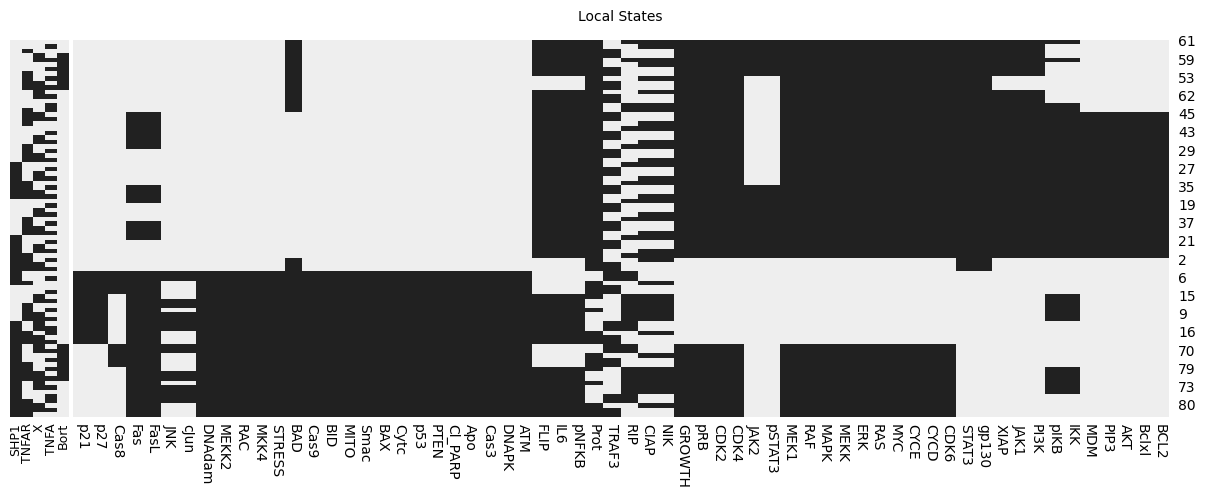

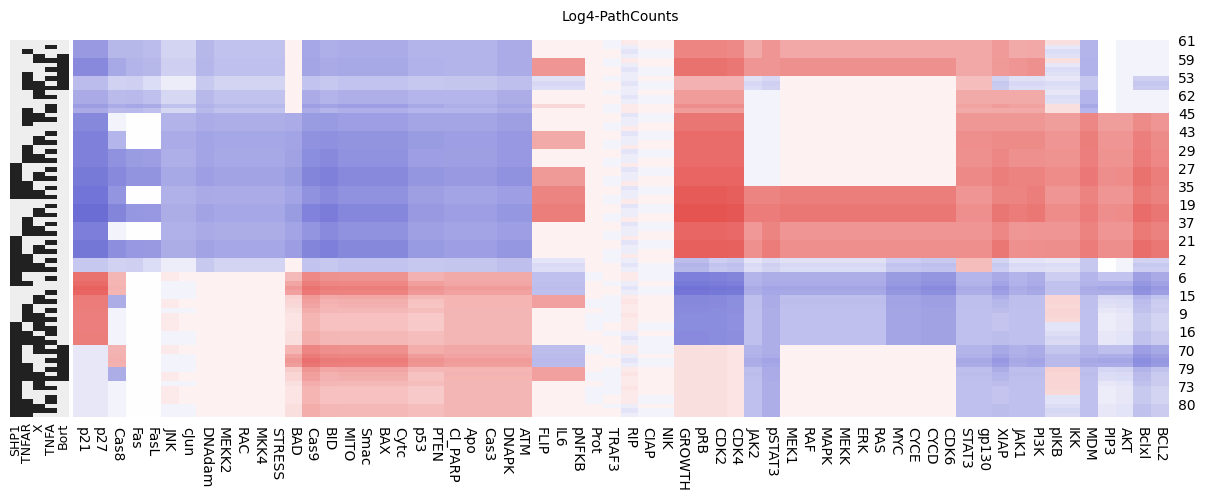

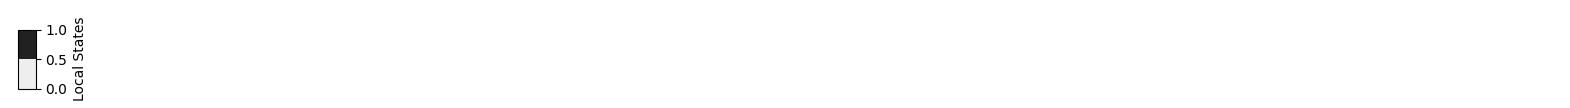

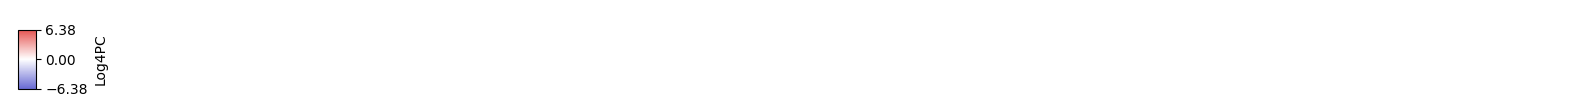

In [13]:
#Plot Report
sim_sum5 = simmulation_summary(model, pc)
display(sim_sum5.style.hide(axis = "index"))
with contextlib.redirect_stdout(io.StringIO()):
    plt.figure(figsize=(15, 5)); ls.plot()
    plt.figure(figsize=(15, 5)); paths.plot()
    plt.figure(figsize=(20, 1)); ls.plot_legends()
    plt.figure(figsize=(20, 1)); paths.plot_legends()

<div style="font-size:90%;">

**Figure 5.** Heatmaps showing the Boolean states (top) and the corresponding transduction path counts (bottom), calculated using BooLEVARD, for the stable states reached by the Bortezomib Responses in U266 Human Myeloma Cells Boolean Model. The Boolean activation states of the input nodes (*SHP1*, *TNFAR*, *X*, *TNFA*, *Bort*) that drive each stable state are shown to the left of both heatmaps (black = ON, white = OFF). Path counts are shown on a signed logarithmic scale (Log₄ of the number of activating or inhibitory paths). Red indicates a high number of activating paths toward a node; blue indicates inhibitory paths. Rows (stable states) and columns (nodes) have been clustered using Euclidean distance to highlight patterns across conditions and model components.

</div>

<h5 style="margin-top: 00px; margin-bottom: 2px;" id="section-6"><b>6.- MAPK Cancer Cell Fate Network</b><a href="#section-0" style="font-size: 12px;"> [back]</a></h5>
<p>

This model captures the complex dynamics of the **MAPK signaling network**, which regulates crucial cellular processes such as proliferation, differentiation, survival, and apoptosis. The network integrates multiple signaling branches relevant in cancer biology, where its desregulation is associated with tumor progression and therapy resistance. Focusing on urinary bladder cancer, the model incorporates key components and interactions derived from extensive literature curation, and was developed to explore how combinations of stimuli and perturbations influence cell fate decisions, providing mechanistic hypotheses to explain divergent cellular behaviors in response to oncogenic signals.
<p style="font-size:90%; color:gray;">
Grieco L, Calzone L, Bernard-Pierrot I, Radvanyi F, Kahn-Perlès B, et al. (2013).  
<i>Integrative Modelling of the Influence of MAPK Network on Cancer Cell Fate Decision.</i>  
PLOS Computational Biology 9(10): e1003286.  
<a href="https://doi.org/10.1371/journal.pcbi.1003286" target="_blank">https://doi.org/10.1371/journal.pcbi.1003286</a>
</p>

In [14]:
# Run analysis
# Select model and convert SBML to BoolNet format
model_name = models_repo[5]
model_path = f"{bnet_dir}{model_name}.bnet"
sbml2bnet((f"{sbml_dir}{model_name}.sbml"), (f"{bnet_dir}{model_name}.bnet"))
# Load the BoolNet model, extract nodes and count paths
model = blv.Load(model_path)
nodes = model.Nodes; edges = 104
sys.stdout = open(os.devnull, 'w')
start_time = time.time()
pc = model.CountPaths(nodes, ss_wise = True)
end_time = time.time()
sys.stdout = sys.__stdout__
sim_time = end_time - start_time
ls, paths = Report(model, pc) # ls will contain stable state analysis results and paths will contain BooLEVARD's results

Simulation time (s),Stable states,Nodes,Edges,Inputs,Paths,Avg time / state (s),Avg time / node (s),Avg time / path (s)
0.582423,12,53,104,4,14507,0.048535,0.000916,0.000040


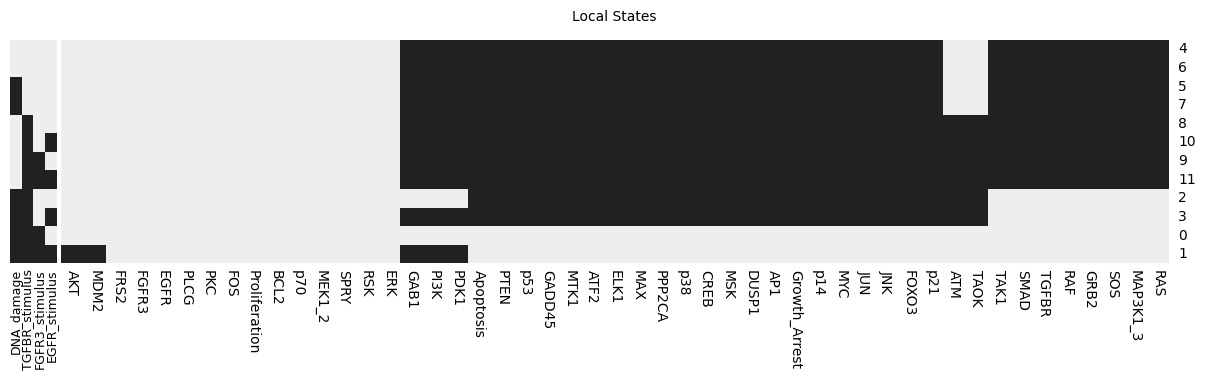

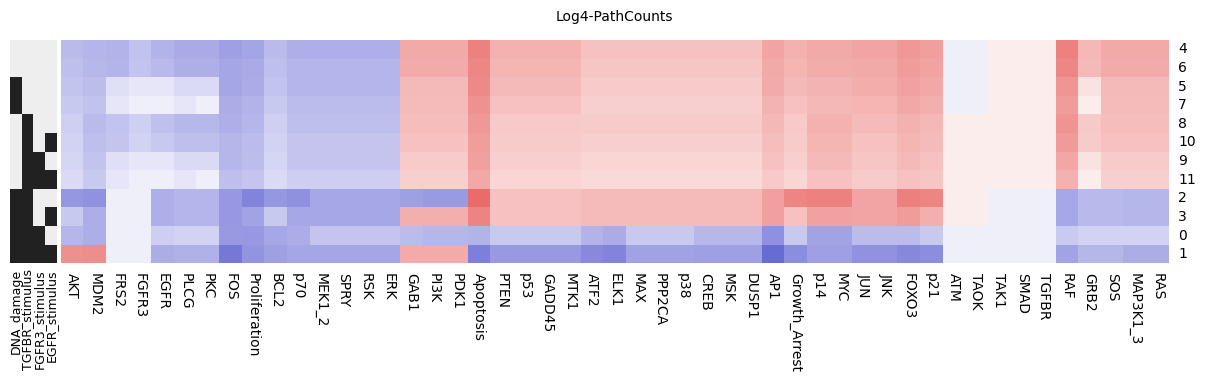

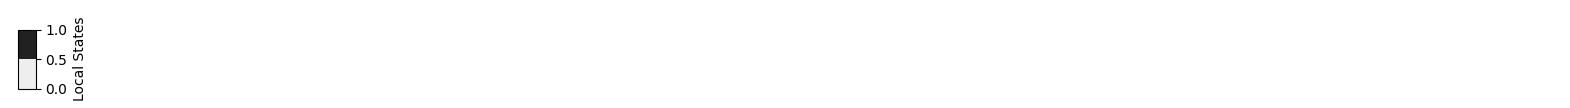

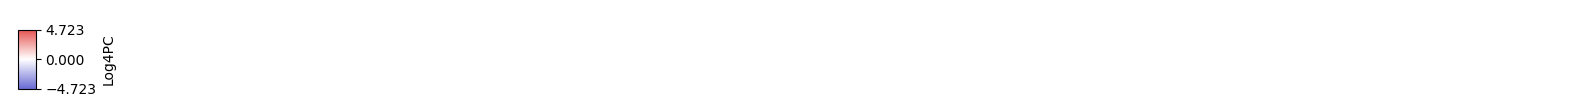

In [15]:
#Plot Report
sim_sum6 = simmulation_summary(model, pc)
display(sim_sum6.style.hide(axis = "index"))
with contextlib.redirect_stdout(io.StringIO()):
    plt.figure(figsize=(15, 3)); ls.plot()
    plt.figure(figsize=(15, 3)); paths.plot()
    plt.figure(figsize=(20, 1)); ls.plot_legends()
    plt.figure(figsize=(20, 1)); paths.plot_legends()

<div style="font-size:90%;">

**Figure 6.** Heatmaps showing the Boolean states (top) and the corresponding transduction path counts (bottom), calculated using BooLEVARD, for the stable states reached by the MAPK Cancer Cell Fate Network Boolean Model. The Boolean activation states of the input nodes (*DNA_damage*, *TGFBR_stimulus*, *FGFR3_stimulus*, *EGFR_stimulus*) that drive each stable state are shown to the left of both heatmaps (black = ON, white = OFF). Path counts are shown on a signed logarithmic scale (Log₄ of the number of activating or inhibitory paths). Red indicates a high number of activating paths toward a node; blue indicates inhibitory paths. Rows (stable states) and columns (nodes) have been clustered using Euclidean distance to highlight patterns across conditions and model components.

</div>

<h5 style="margin-top: 00px; margin-bottom: 2px;" id="section-7"><b>7.- IL-1 Signaling</b><a href="#section-0" style="font-size: 12px;"> [back]</a></h5>
<p>

This model captures the complex dynamics of the IL-1 signaling mechanisms, which regulate crucial cellular processes such as immune coordination upon infection or injury, mitogenic and pro-proliferative signaling, apoptosis, inhibition, chemotaxis, and angiogenesis, thereby balancing tissue regeneration against invasive growth, tumorigenesis, and metastasis. The network integrates multiple stimulus-response branches, including feedback and feed-forward loops, whose dysregulation is implicated not only in cancer progression, but also in insulin ressitance. The model incorporates extensive literature-curated components and is optimized with high-throughput phosphoproteomic data.
<p style="font-size:90%; color:gray;">
Ryll A, Samaga R, Schaper F, Alexopoulos LG, Klamt S, et al. (2011).  
<i>Large-scale network models of IL-1 and IL-6 signalling and their hepatocellular specification.</i>  
Mol Biosyst. 7(12):3253–70.  
<a href="https://doi.org/10.1039/c1mb05261f" target="_blank">https://doi.org/10.1039/c1mb05261f</a>
</p>


In [16]:
# Run analysis
# Select model and convert SBML to BoolNet format
model_name = models_repo[6]
model_path = f"{bnet_dir}{model_name}.bnet"
sbml2bnet((f"{sbml_dir}{model_name}.sbml"), (f"{bnet_dir}{model_name}.bnet"))
# Load the BoolNet model, extract nodes and count paths
model = blv.Load(model_path)
nodes = model.Nodes; edges = 218
sys.stdout = open(os.devnull, 'w')
start_time = time.time()
pc = model.CountPaths(nodes, ss_wise = True)
end_time = time.time()
sys.stdout = sys.__stdout__
sim_time = end_time - start_time
ls, paths = Report(model, pc) # ls will contain stable state analysis results and paths will contain BooLEVARD's results

Simulation time (s),Stable states,Nodes,Edges,Inputs,Paths,Avg time / state (s),Avg time / node (s),Avg time / path (s)
3329.976674,16384,118,218,14,547646464,0.203246,0.001722,0.000006


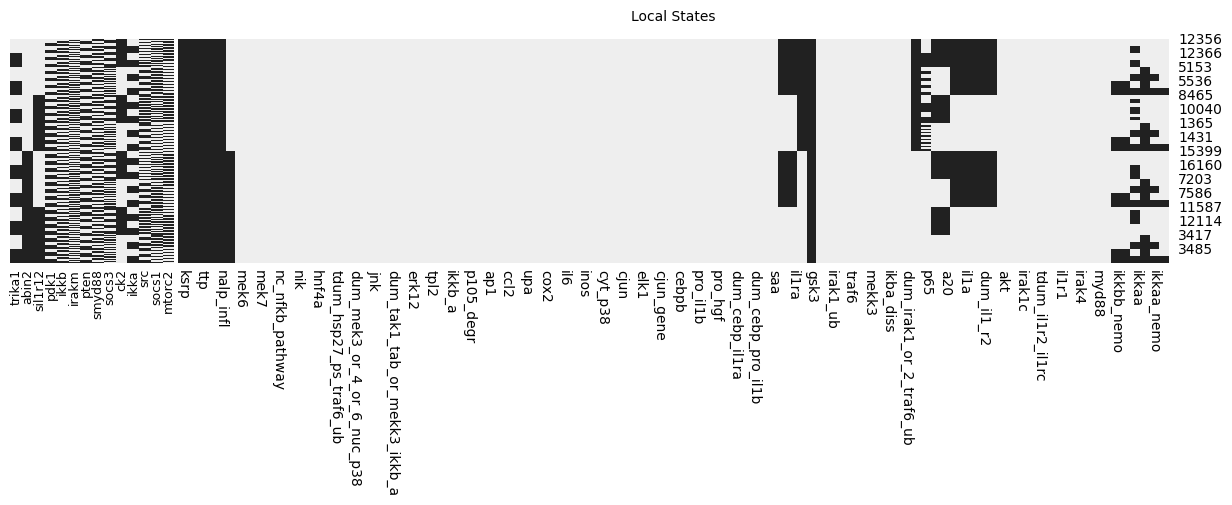

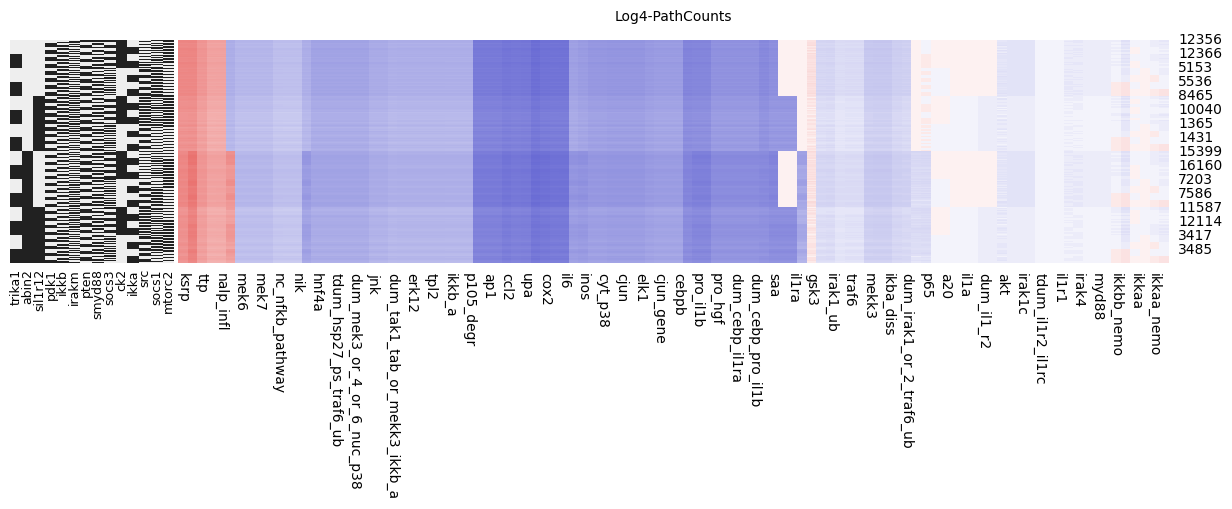

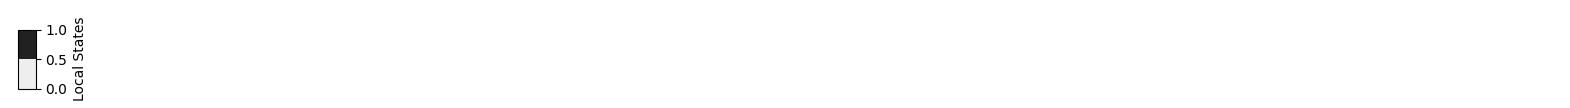

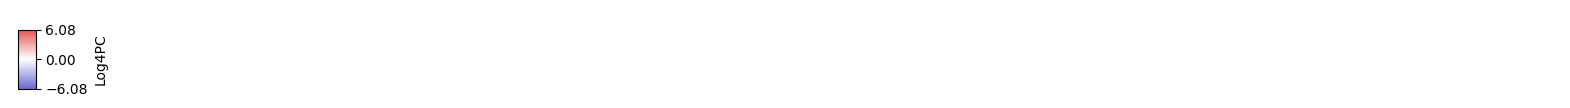

In [17]:
#Plot Report
sim_sum7 = simmulation_summary(model, pc)
display(sim_sum7.style.hide(axis = "index"))
with contextlib.redirect_stdout(io.StringIO()):
    plt.figure(figsize=(15, 3)); ls.plot()
    plt.figure(figsize=(15, 3)); paths.plot()
    plt.figure(figsize=(20, 1)); ls.plot_legends()
    plt.figure(figsize=(20, 1)); paths.plot_legends()

<h5 style="margin-top: 00px; margin-bottom: 2px;" id="section-8"><b>8.- IL-6 Signaling</b><a href="#section-0" style="font-size: 12px;"> [back]</a></h5>
<p>

This model captures the complex dynamics of the IL-6 signaling mechanisms, which regulate crucial cellular processes such as immune coordination upon infection or injury, mitogenic and pro-proliferative signaling, apoptosis, inhibition, chemotaxis, and angiogenesis, thereby balancing tissue regeneration against invasive growth, tumorigenesis, and metastasis. The network integrates multiple stimulus-response branches, including feedback and feed-forward loops, whose dysregulation is implicated not only in cancer progression, but also in insulin ressitance. The model incorporates extensive literature-curated components and is optimized with high-throughput phosphoproteomic data.
<p style="font-size:90%; color:gray;">
Ryll A, Samaga R, Schaper F, Alexopoulos LG, Klamt S, et al. (2011).  
<i>Large-scale network models of IL-1 and IL-6 signalling and their hepatocellular specification.</i>  
Mol Biosyst. 7(12):3253–70.  
<a href="https://doi.org/10.1039/c1mb05261f" target="_blank">https://doi.org/10.1039/c1mb05261f</a>
</p>


In [18]:
# Run analysis
# Select model and convert SBML to BoolNet format
model_name = models_repo[7]
model_path = f"{bnet_dir}{model_name}.bnet"
sbml2bnet((f"{sbml_dir}{model_name}.sbml"), (f"{bnet_dir}{model_name}.bnet"))
# Load the BoolNet model, extract nodes and count paths
model = blv.Load(model_path)
nodes = model.Nodes; edges = 149
sys.stdout = open(os.devnull, 'w')
start_time = time.time()
pc = model.CountPaths(nodes, ss_wise = True)
end_time = time.time()
sys.stdout = sys.__stdout__
sim_time = end_time - start_time
ls, paths = Report(model, pc) # ls will contain stable state analysis results and paths will contain BooLEVARD's results

Simulation time (s),Stable states,Nodes,Edges,Inputs,Paths,Avg time / state (s),Avg time / node (s),Avg time / path (s)
3109.330825,28672,86,149,15,48626432,0.108445,0.001261,0.000064


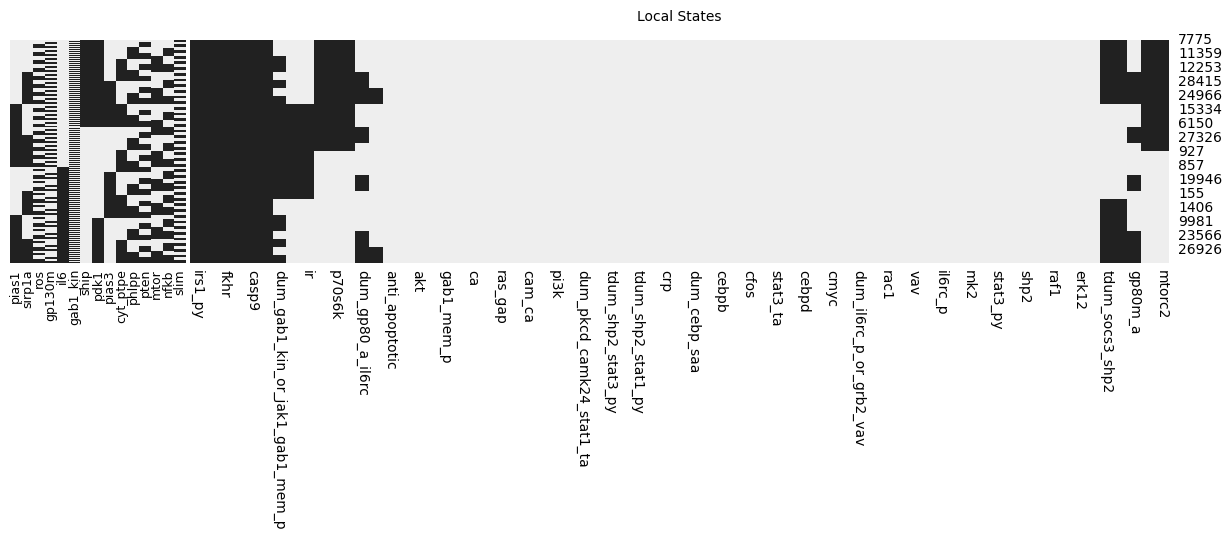

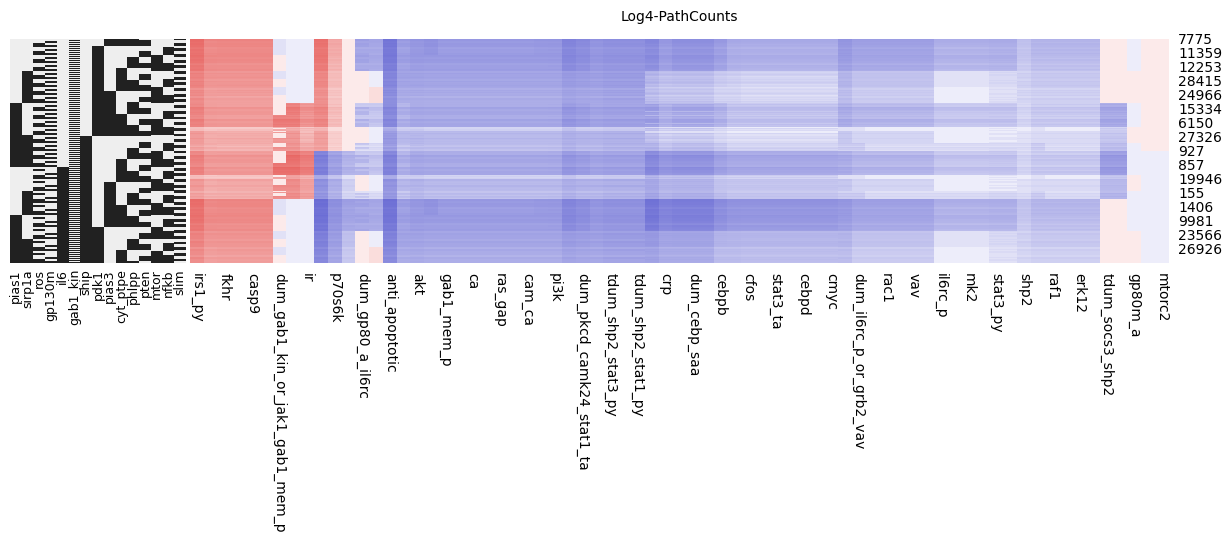

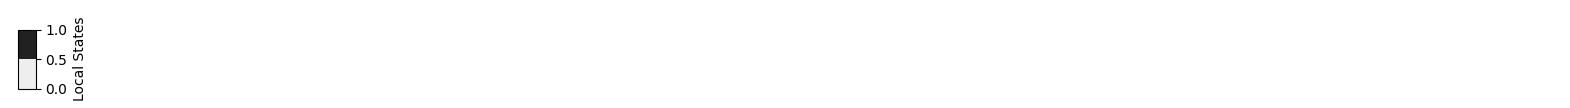

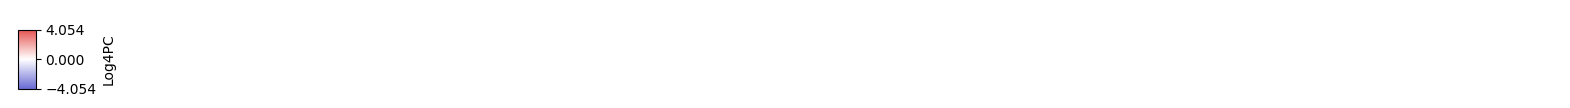

In [19]:
#Plot Report
sim_sum8 = simmulation_summary(model, pc)
display(sim_sum8.style.hide(axis = "index"))
with contextlib.redirect_stdout(io.StringIO()):
    plt.figure(figsize=(15, 3)); ls.plot()
    plt.figure(figsize=(15, 3)); paths.plot()
    plt.figure(figsize=(20, 1)); ls.plot_legends()
    plt.figure(figsize=(20, 1)); paths.plot_legends()

<h5 style="margin-top: 00px; margin-bottom: 2px;" id="section-9"><b>9.- Tumor Cell Invasion</b><a href="#section-0" style="font-size: 12px;"> [back]</a></h5>
<p>

This model captures the complex dynamics of the **early metastatic cascade**, which regulates crucial cellular processes such as local invasion and migration. The network integrates multiple signaling branches relevant in cancer biology, where its dysregulation is associated with metastatic dissemination and patient mortality. Focusing on TGF-beta-driven epithelial-to-mesenchymal transition in lung cancer and validated against transcriptome dynamics and mouse models, the model incorporates key components and interactions derived from extensive literature curation.
<p style="font-size:90%; color:gray;">
Cohen DPA, Martignetti L, Robine S, Barillot E, Zinovyev A, et al. (2015).  
<i>Mathematical Modelling of Molecular Pathways Enabling Tumour Cell Invasion and Migration.</i>  
PLOS Computational Biology 11(11): e1004571.  
<a href="https://doi.org/10.1371/journal.pcbi.1004571" target="_blank">https://doi.org/10.1371/journal.pcbi.1004571</a>
</p>


In [20]:
# Run analysis
# Select model and convert SBML to BoolNet format
model_name = models_repo[8]
model_path = f"{bnet_dir}{model_name}.bnet"
sbml2bnet((f"{sbml_dir}{model_name}.sbml"), (f"{bnet_dir}{model_name}.bnet"))
# Load the BoolNet model, extract nodes and count paths
model = blv.Load(model_path)
nodes = model.Nodes; edges = 218
sys.stdout = open(os.devnull, 'w')
start_time = time.time()
pc = model.CountPaths(nodes, ss_wise = True)
end_time = time.time()
sys.stdout = sys.__stdout__
sim_time = end_time - start_time
ls, paths = Report(model, pc) # ls will contain stable state analysis results and paths will contain BooLEVARD's results

Simulation time (s),Stable states,Nodes,Edges,Inputs,Paths,Avg time / state (s),Avg time / node (s),Avg time / path (s)
18.985098,9,32,218,2,4487867,2.109455,0.065920,0.000004


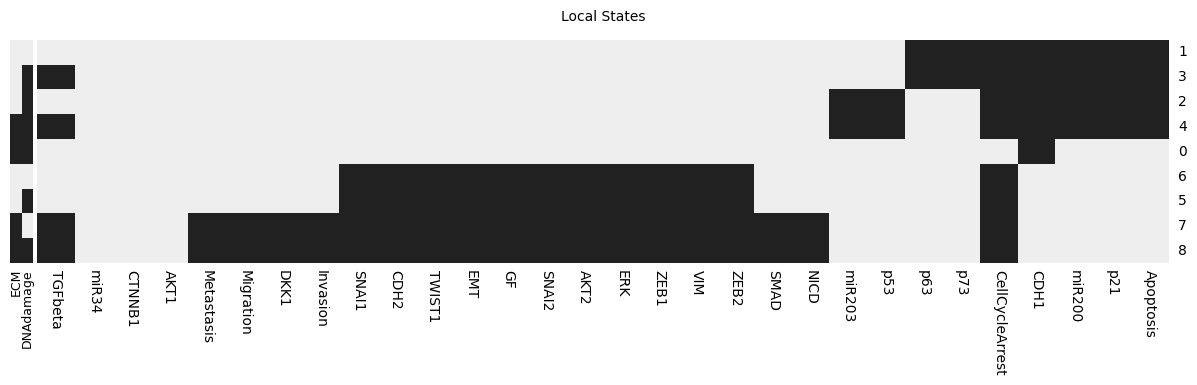

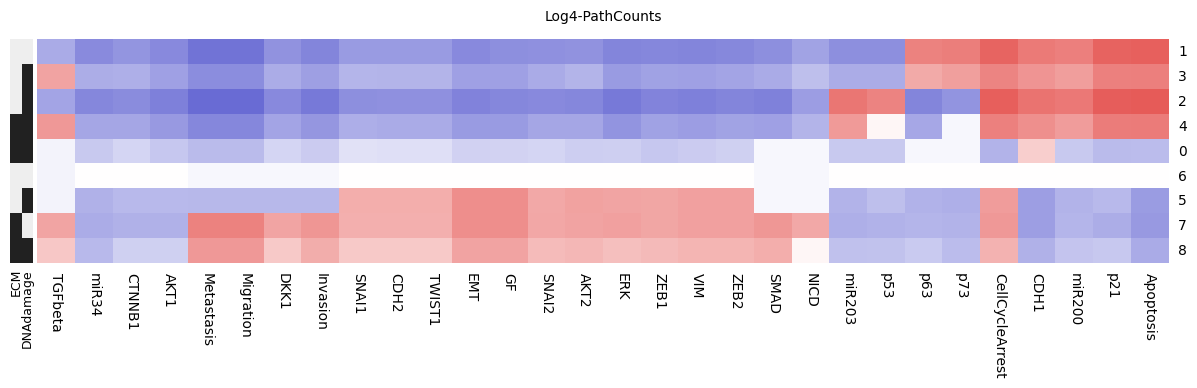

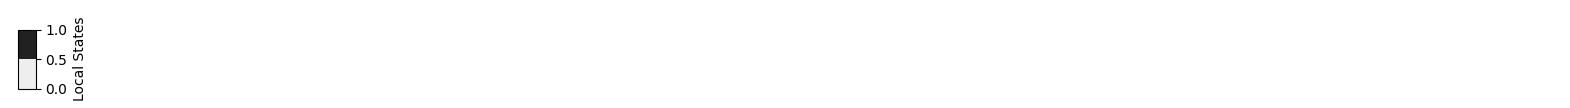

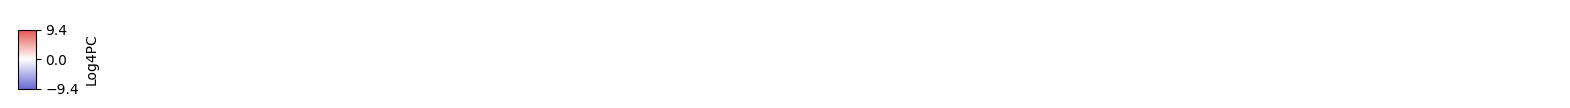

In [21]:
#Plot Report
sim_sum9 = simmulation_summary(model, pc)
display(sim_sum9.style.hide(axis = "index"))
with contextlib.redirect_stdout(io.StringIO()):
    plt.figure(figsize=(15, 3)); ls.plot()
    plt.figure(figsize=(15, 3)); paths.plot()
    plt.figure(figsize=(20, 1)); ls.plot_legends()
    plt.figure(figsize=(20, 1)); paths.plot_legends()